In [1]:
%matplotlib inline
import os
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt

from tensorpack.dataflow.common import MapData, BatchData
from tensorpack.dataflow.parallel import PrefetchData

sys.path.append('..')

from training.dataflow import CocoDataFlow, JointsLoader, COCODataPaths
from training.dataset import read_img, gen_mask, augment, apply_mask, \
    create_all_mask, ALL_HEATMAP_MASK, ALL_PAF_MASK, build_sample, batch_dataflow
from training.label_maps import create_heatmap, create_paf
from training.train_pose import gen

Using TensorFlow backend.


In [2]:
batch_size = 1

annot_path = '../dataset/annotations/person_keypoints_val2017.json'
img_dir = '../dataset/val2017/'
df = CocoDataFlow((368, 368), COCODataPaths(annot_path, img_dir))#,select_ids=[1000])
df.prepare()
df = MapData(df, read_img)
df = MapData(df, gen_mask)
df = MapData(df, augment)
df = MapData(df, apply_mask)
df = MapData(df, build_sample)
df = PrefetchData(df, nr_prefetch=1, nr_proc=1)

g = gen(batch_dataflow(df, batch_size))

loading annotations into memory...
Done (t=0.29s)
creating index...
index created!
Loading dataset ../dataset/val2017/ ...
Loading image annot 0/5000
Loading image annot 2000/5000
Loading image annot 4000/5000
[1115 20:28:23 @argtools.py:152] WRN Install python-prctl so that processes can be cleaned with guarantee.


In [3]:
x,y = next(g)    

print('Shapes')
print(x[0].shape)
print(x[1].shape)
print(x[2].shape)
print('----')
print(y[0].shape)
print(y[1].shape)
print(y[2].shape)
print(y[3].shape)
print(y[4].shape)
print(y[5].shape)
print(y[6].shape)
print(y[7].shape)
print(y[8].shape)
print(y[9].shape)
print(y[10].shape)
print(y[11].shape)
print('Types')
print(x[0].dtype)
print(x[1].dtype)
print(x[2].dtype)
print('----')
print(y[0].dtype)
print(y[1].dtype)
print(y[2].dtype)
print(y[3].dtype)
print(y[4].dtype)
print(y[5].dtype)
print(y[6].dtype)
print(y[7].dtype)
print(y[8].dtype)
print(y[9].dtype)
print(y[10].dtype)
print(y[11].dtype)

Shapes
(1, 368, 368, 3)
(1, 46, 46, 38)
(1, 46, 46, 19)
----
(1, 46, 46, 38)
(1, 46, 46, 19)
(1, 46, 46, 38)
(1, 46, 46, 19)
(1, 46, 46, 38)
(1, 46, 46, 19)
(1, 46, 46, 38)
(1, 46, 46, 19)
(1, 46, 46, 38)
(1, 46, 46, 19)
(1, 46, 46, 38)
(1, 46, 46, 19)
Types
uint8
uint8
uint8
----
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64


## Image + mask

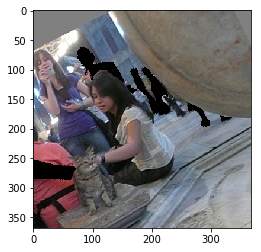

In [11]:
img = x[0][0,...]
mask_paf = x[1][0,...]
mask_heatmap = x[2][0,...]
pafmap = y[0][0,...]
heatmap = y[1][0,...]

plt.imshow(img[:,:,[2,1,0]])

## Mask

0
1
uint8


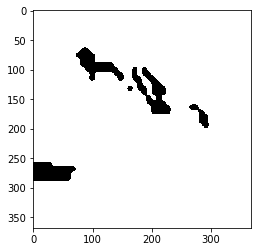

In [12]:
plt.imshow(mask_img * 255, cmap='gray')
import numpy as np
print (np.min(mask_img))
print (np.max(mask_img))
print (mask_img.dtype)

## Heatmap

float64
1.0
0.0


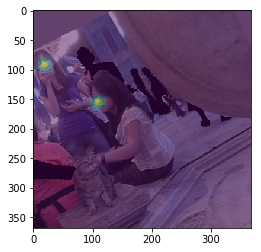

In [13]:
body_part = 0

heatmap1 = cv2.resize(heatmap[:, :, body_part], (0,0), fx=8, fy=8, interpolation=cv2.INTER_CUBIC)

plt.imshow(img[:,:,[2,1,0]])
plt.imshow(heatmap1[:,:], alpha=.5)

print (heatmap.dtype)
print (np.max(heatmap))
print (np.min(heatmap))

## PAF dx

float64
0.8578468602473046
-0.12977127202880348


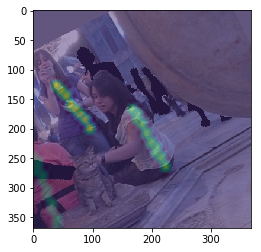

In [14]:
paf_num = 6

pafmap1 = cv2.resize(pafmap[:, :, paf_num], (0,0), fx=8, fy=8, interpolation=cv2.INTER_CUBIC)

plt.imshow(img[:,:,[2,1,0]])
plt.imshow(pafmap1, alpha=.5)

print (pafmap1.dtype)
print (np.max(pafmap1))
print (np.min(pafmap1))

## PAF dy

float64
1.2015043059538626
-0.22588914358735937


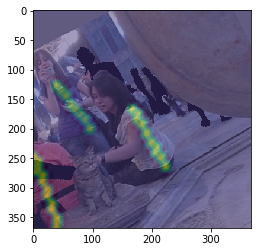

In [15]:
paf_num = 7

pafmap2 = cv2.resize(pafmap[:, :, paf_num], (0,0), fx=8, fy=8, interpolation=cv2.INTER_CUBIC)

plt.imshow(img[:,:,[2,1,0]])
plt.imshow(pafmap2, alpha=.5)

print (pafmap2.dtype)
print (np.max(pafmap2))
print (np.min(pafmap2))

## PAF vectors

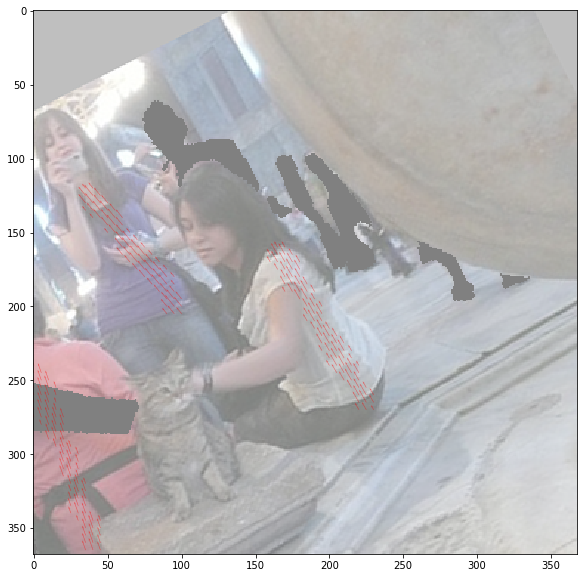

In [16]:
from numpy import ma

paf_num1 = 6
paf_num2 = 7

U = cv2.resize(pafmap[:,:,paf_num1], (0,0), fx=8, fy=8, interpolation=cv2.INTER_CUBIC) * -1
V = cv2.resize(pafmap[:,:,paf_num2], (0,0), fx=8, fy=8, interpolation=cv2.INTER_CUBIC)
X, Y = np.meshgrid(np.arange(U.shape[1]), np.arange(U.shape[0]))
M = np.zeros(U.shape, dtype='bool')
M[U**2 + V**2 < 0.5 * 0.5] = True
U = ma.masked_array(U, mask=M)
V = ma.masked_array(V, mask=M)

plt.figure()
plt.imshow(img[:,:,[2,1,0]], alpha = .5)
s = 5
Q = plt.quiver(X[::s,::s], Y[::s,::s], U[::s,::s], V[::s,::s], 
               scale=50, headaxislength=4, alpha=.5, width=0.001, color='r')

fig = plt.gcf()
fig.set_size_inches(10, 10)